# Linear Regression

<!-- [![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)]() -->

Acknowledgement: This notebook is modified from the original [tutorial](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/linear_regression/linear_regression.ipynb) of the open-source tool [CoFI](https://cofi.readthedocs.io/en/latest/index.html), the Common Framework for Inference, to demonstrate several approaches to solve the parameter estimation problem to a polynomial.

We use the original functions from different software packages as a demonstration in this notebook. However, readers are encouraged to explore the original notebook to see how [CoFI](https://cofi.readthedocs.io/en/latest/index.html) bridges several concepts across inversioninto a unified framework.

---

## What we do in this notebook
Here we demonstrate several ways to approach a simple **linear regression** problem, where we fit a polynomial function to data using three different algorithms:

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

<!-- ---

## Learning outcomes

- A demonstration of running CoFI for a class of parameter fitting problem.  Example of a CoFI **template**.
- A demonstration of how CoFI may be used to  **experiment with different inference approaches** under a common interface.
- A demonstration of CoFI's **expandability** in that it may be used with pre-set, or user defined, misfits, likelihood or priors.   -->


In [1]:
# Environment setup (uncomment code below)

# !pip install -U emcee # -U to install on a local account

---
## Preparation

Let's start with some `(x,y)` data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# here is some (x,y) data
data_x = np.array([1.1530612244897958, -0.07142857142857162, -1.7857142857142858,
                1.6428571428571423, -2.642857142857143, -1.0510204081632653,
                1.1530612244897958, -1.295918367346939, -0.806122448979592,
                -2.2755102040816326, -2.2755102040816326, -0.6836734693877551,
                0.7857142857142856, 1.2755102040816322, -0.6836734693877551,
                -3.2551020408163267, -0.9285714285714288, -3.377551020408163,
                -0.6836734693877551, 1.7653061224489797])

data_y = np.array([-7.550931153863841, -6.060810406314714, 3.080063056254076,
                -4.499764131508964, 2.9462042659962333, -0.4645899453212615,
                -7.43068837808917, 1.6273774547833582, -0.05922697815443567,
                3.8462283231266903, 3.425851020301113, -0.05359797104829345,
                -10.235538857712598, -5.929113775071286, -1.1871766078924957,
                -4.124258811692425, 0.6969191559961637, -4.454022624935177,
                -2.352842192972056, -4.25145590011172])
sigma = 1   # estimation on the data noise

And now lets plot the data.

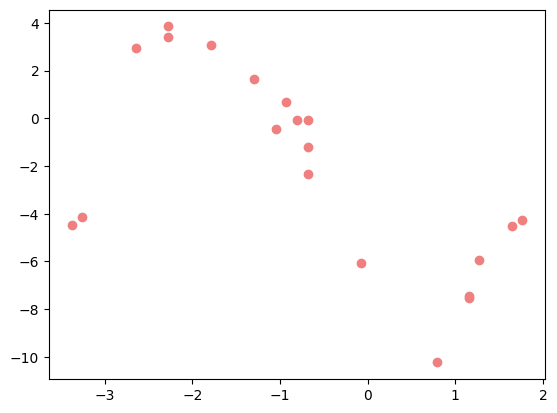

In [4]:
def plot_data(sigma=None):
    if(sigma is None):
        plt.scatter(data_x, data_y, color="lightcoral", label="observed data")
    else:
        plt.errorbar(data_x, data_y, yerr=sigma, fmt='.', color="lightcoral", ecolor='lightgrey', ms=10)
plot_data()

---
## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem, the forward operator takes the following linear form:

$$\left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\\m_3\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2, m_3$), where $M=3$;
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).

We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is : $y=-6-5x+2x^2+x^3$, and we have added Gaussian random noise, ${N}(0,\sigma^2)$, with $\sigma=1.0$.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [5]:
nparams = 4 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sigma, ndata=len(data_x)):
    return 1/sigma**2 * np.identity(ndata)

Define the true model for later.

In [6]:
# True model for plotting
x = np.linspace(-3.5,2.5)              # x values to plot
true_model = np.array([-6, -5, 2, 1])  # we know it for this case which will be useful later for comparison.

true_y = jacobian(x,4).dot(true_model) # y values for true curve

Now lets plot the data with the curve from the true polynomial coefficients.

In [7]:
# Some plotting utilities
def plot_model(x,y, label, color=None):
    #x = np.linspace(-3.5,2.5)
    #y = jacobian(x).dot(model)
    plt.plot(x, y, color=color or "green", label=label)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1):
    x = np.linspace(-3.5,2.5)
    G = jacobian(x)
    plt.plot(x, G.dot(models[0]), color=color, label=label, alpha=alpha)
    for m in models:
        plt.plot(x, G.dot(m), color=color, alpha=alpha)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

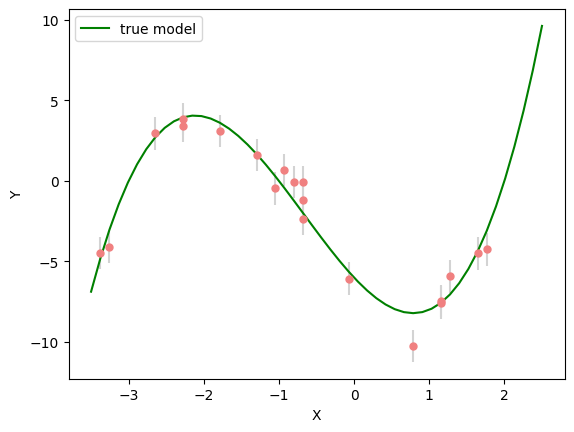

In [8]:
plot_data(sigma=sigma)
plot_model(x,true_y, "true model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

---
## 1. Linear system solver

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

In [9]:
# Jacobian matrix corresponding to known data_x
G = jacobian()
# Analytical least square solution
L = G.T @ Cd_inv() @ G # @ is a short form for np.matmul, i.e., matrix multiplication
R = G.T @ Cd_inv() @ data_y
m = np.linalg.inv(L) @ R
print (m)

[-5.71964359 -5.10903808  1.82553662  0.97472374]


In [10]:
from scipy.linalg import lstsq

m = lstsq(G, data_y)
print(m[0])

[-5.71964359 -5.10903808  1.82553662  0.97472374]


Lets plot the solution.

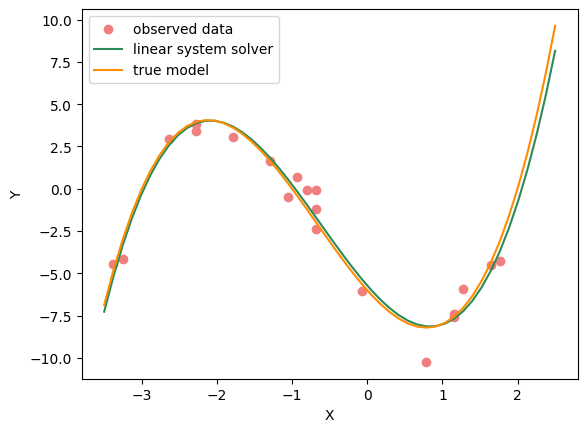

In [11]:
plot_data()
plot_model(x,jacobian(x).dot(m[0]), "linear system solver", color="seagreen")
plot_model(x,true_y, "true model", color="darkorange")

---
## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with
CoFI. In the example below we provide functions to calculate the data and the optional
regularisation. CoFI then generates the objective function for us based on the information
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [12]:
def misfit(m):
    return np.sum((jacobian() @ m - data_y)**2)

from scipy.optimize import minimize
res = minimize(misfit, np.ones(nparams), method='Nelder-Mead')
print (res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14.961508008942802
             x: [-5.720e+00 -5.109e+00  1.826e+00  9.747e-01]
           nit: 193
          nfev: 330
 final_simplex: (array([[-5.720e+00, -5.109e+00,  1.826e+00,  9.747e-01],
                       [-5.720e+00, -5.109e+00,  1.826e+00,  9.747e-01],
                       ...,
                       [-5.720e+00, -5.109e+00,  1.826e+00,  9.747e-01],
                       [-5.720e+00, -5.109e+00,  1.826e+00,  9.747e-01]]), array([ 1.496e+01,  1.496e+01,  1.496e+01,  1.496e+01,
                        1.496e+01]))



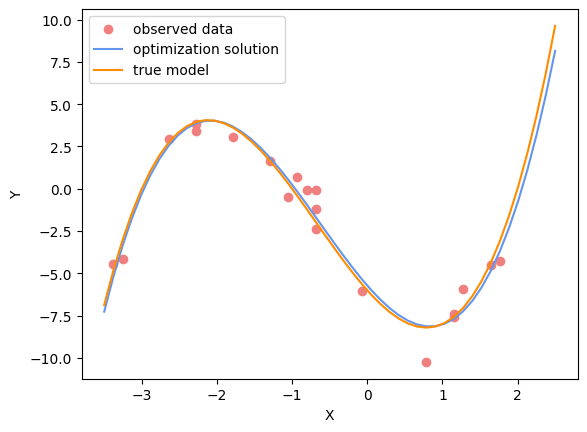

In [13]:
plot_data()
plot_model(x,jacobian(x).dot(res.x), "optimization solution", color="cornflowerblue")
plot_model(x,true_y, "true model", color="darkorange")

### Challenge: Change the polynomial degree

Try and replace the 3rd order polynomial with a 1st order polynomial (i.e. $M=1$) by adding the required commands below. What does the plot looks like?

[![Upload to Excalidraw_1](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=351ca2833e3ad8315d6a,HzlQfpPleYrpXT8GaoD_cg)

Start from code below:

```
G = jacobian(x=data_x, n=2)
# Analytical least square solution
L = <CHANGE ME>
R = <CHANGE ME>
m = np.linalg.inv(L) @ R

print("Inferred curve with n = 2 ")
plot_data()
plot_model(x,jacobian(x,2)@m, "optimization solution", color="cornflowerblue")
plot_model(x,true_y, "true model", color="darkorange")
```

In [14]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 2 


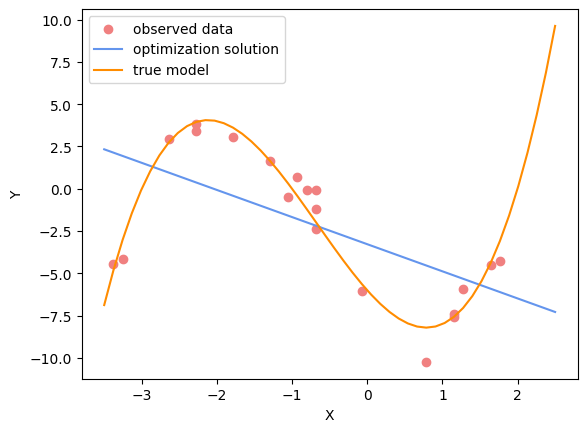

In [15]:
#@title Solution

# Jacobian matrix corresponding to known data_x
G = jacobian(x=data_x, n=2)
# Analytical least square solution
L = G.T @ Cd_inv() @ G # @ is a short form for np.matmul, i.e., matrix multiplication
R = G.T @ Cd_inv() @ data_y
m = np.linalg.inv(L) @ R

print("Inferred curve with n = 2 ")
plot_data()
plot_model(x,jacobian(x,2)@m, "optimization solution", color="cornflowerblue")
plot_model(x,true_y, "true model", color="darkorange")

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$.

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

In [16]:
sigma = 1.0                                     # common noise standard deviation
Cdinv = np.eye(len(data_y))/(sigma**2)      # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior probability

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [17]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

In [18]:
def log_probbability(model):
    return log_prior(model) + log_likelihood(model)

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [19]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Initiate an EnsembleSampler and run it

In [20]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probbability)
output = sampler.run_mcmc(walkers_start, 10000, progress=True)

100%|██████████| 10000/10000 [00:07<00:00, 1252.72it/s]


In [21]:
import arviz as az

labels = ["m0", "m1", "m2","m3"]

az_idata = az.from_emcee(sampler, var_names=labels)

In [22]:
az_idata.get("posterior")

<xarray.Dataset> Size: 10MB
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 256B 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 3MB 0.0002221 0.0002645 ... -6.131 -6.223
    m1       (chain, draw) float64 3MB 0.0001276 0.0001418 ... -5.176 -5.295
    m2       (chain, draw) float64 3MB 2.755e-05 4.594e-05 ... 2.068 2.222
    m3       (chain, draw) float64 3MB 4.631e-05 7.396e-05 ... 1.051 1.106
Attributes:
    created_at:                 2025-03-26T12:10:04.694067+00:00
    arviz_version:              0.21.0
    inference_library:          emcee
    inference_library_version:  3.1.6

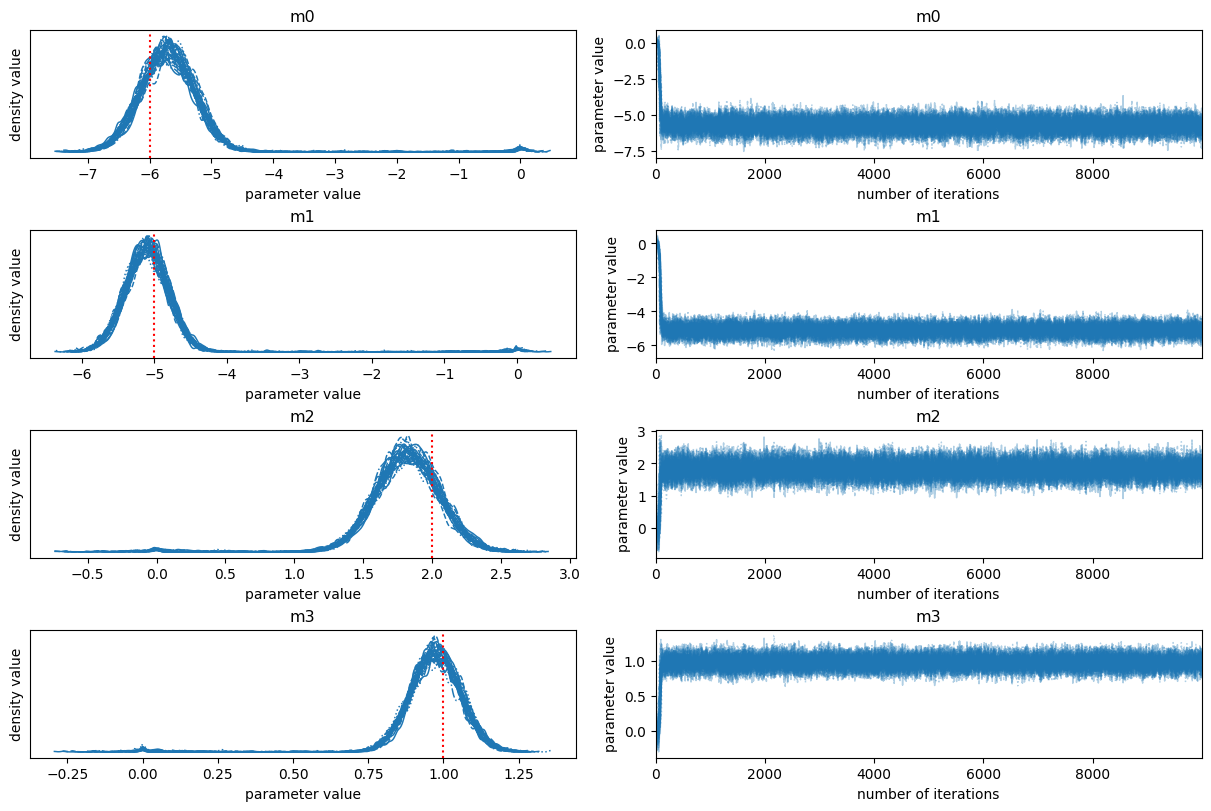

In [23]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True});

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [24]:
tau = sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [78.29747147 87.44291972 64.20632811 74.92448813]


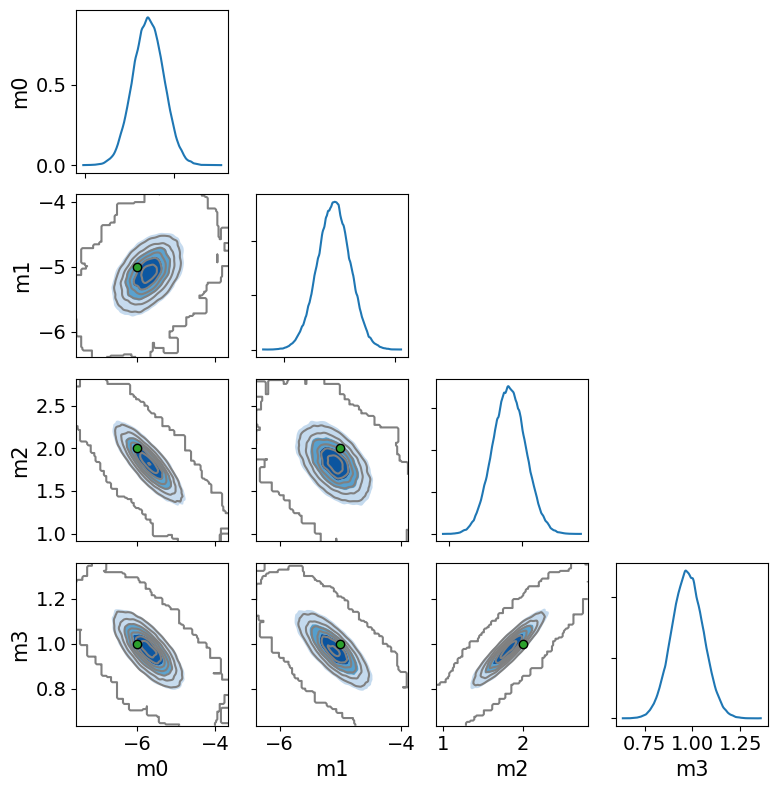

In [25]:
# a Corner plot
fig, axes = plt.subplots(nparams, nparams, figsize=(8,8))

if(False): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)),
        marginals=True,
        reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)),
        marginals=True,
        reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );
fig.tight_layout()

Now we plot the predicted curves for the posterior ensemble of solutions.

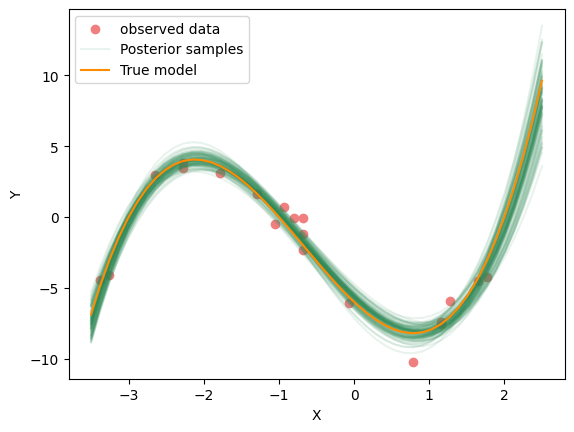

In [26]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data()
plot_models(flat_samples[inds])
plot_model(x,true_y, "True model", color="darkorange")

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [27]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0  -5.715 [ -6.420,  -5.006]
 m1  -5.106 [ -5.599,  -4.636]
 m2   1.824 [  1.457,   2.197]
 m3   0.973 [  0.841,   1.110]


In [28]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 0.18415674  0.05569797 -0.07937281 -0.02487992]
 [ 0.05569797  0.08726284 -0.03204246 -0.01800511]
 [-0.07937281 -0.03204246  0.05117158  0.01684084]
 [-0.02487992 -0.01800511  0.01684084  0.00672315]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.4291
    m1  0.2954
    m2  0.2262
    m3  0.0820


### Challenge 1: Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-1.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (2.,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=feedcdce7f99f8ccd205,wTOddJkDrExrVTcxKsE6kA)

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## re-run the sampler 
sampler.reset()
sampler.run_mcmc(walkers_start, 10000, progress=True)

flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

######## plot the results
print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [29]:
# Copy the template above, Replace <CHANGE ME> with your answer



100%|██████████| 10000/10000 [00:08<00:00, 1213.31it/s]


Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


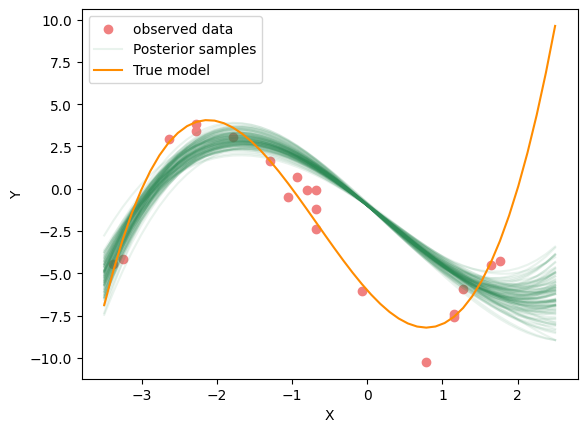

In [30]:
#@title Solution

######## update the problem with the new prior bounds
m_lower_bound = np.array([-1,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([2,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## re-run the sampler 
sampler.reset()
sampler.run_mcmc(walkers_start, 10000, progress=True)

flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

######## plot the results
print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")

Why do you think the posterior distribution looks like this?

### Challenge 2: Change the data uncertainty

To change the data uncertainty we increase `sigma` and then redefine the log-Likelihood.

Here we increase the assumed data standard deviation by a factor of of 50! So we are telling the inversion that the data are far less accurate than they actually are.

In [31]:
sigma = 50.0                                     # common noise standard deviation
Cdinv = np.eye(len(data_y))/(sigma**2)      # inverse data covariance matrix

Lets return the prior to the original bounds.

In [32]:
m_lower_bound = np.ones(4) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(4) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Your challenge is then to tell CoFI that the Likelihood and prior have changed and then to rerun the sample, and plot results.

[![Upload to Excalidraw_3](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=9a22d4eab8a9189d3b9b,9R8JKoHdOsbWlOLBj2V1fQ)

Feel free to start from the code below:

```
######## the likelihood function with the new Cdinv
def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return <CHANGE ME>

######## re-run the sampler
sampler.reset()
sampler.run_mcmc(walkers_start, 10000, progress=True)

flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples from changed data uncertainty")
plot_data()
plot_models(flat_samples[inds])
plot_model(x,true_y, "True model", color="darkorange")
```

In [33]:
# Copy the template above, Replace <CHANGE ME> with your answer



The answer is in the next cells if you want to run them.

100%|██████████| 10000/10000 [00:07<00:00, 1264.35it/s]


Resulting samples from changed data uncertainty


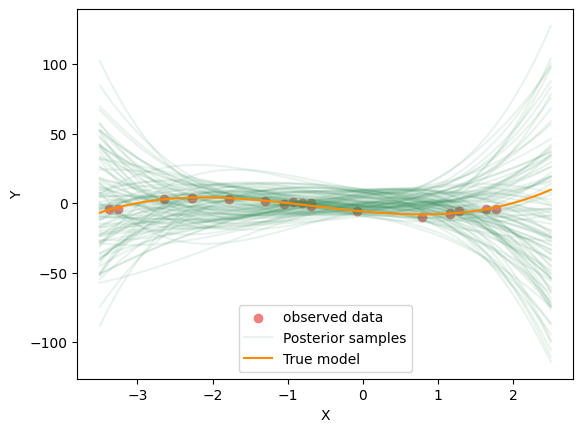

In [34]:
#@title Solution

######## the likelihood function with the new Cdinv
def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

######## re-run the sampler
sampler.reset()
sampler.run_mcmc(walkers_start, 10000, progress=True)

flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples from changed data uncertainty")
plot_data()
plot_models(flat_samples[inds])
plot_model(x,true_y, "True model", color="darkorange")

### Challenge 3: Change the number of walkers / steps in the McMC algorithm (optional)

Now lets decrease the number of steps performed by the McMC algorithm. It will be faster but perform less exploration of the model parameters.

We suggest you reduce the number of steps taken by all 32 random walkers and see how it affects the posterior ensemble.

[![Upload to Excalidraw_4](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=354b4a2d26551847421f,Cqqz1tpuHdT-g0dyMMqJlQ)

You can start from code template below:

```
nsteps = <CHANGE ME>               # instead of 10000
nwalkers = <CHANGE ME>             # instead of 32
# update start with the new number of walkers
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

# let's return to the old uncertainty settings
sigma = 1.0                                 # common noise standard deviation
Cdinv = np.eye(len(data_y))/(sigma**2)      # inverse data covariance matrix

# re-defining the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probbability)

######## re-run the sampler
sampler.run_mcmc(walkers_start, nsteps, progress=True)

######## CoFI InversionResult - plot result
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=10) # get a random selection from posterior ensemble

print(f"Inference results from {nsteps} steps and {nwalkers} walkers")
plot_data()
plot_models(flat_samples[inds])
plot_model(x,true_y, "True model", color="darkorange")
```

In [35]:
# Copy the template above, Replace <CHANGE ME> with your answer



100%|██████████| 400/400 [00:00<00:00, 1295.04it/s]


Inference results from 400 steps and 30 walkers


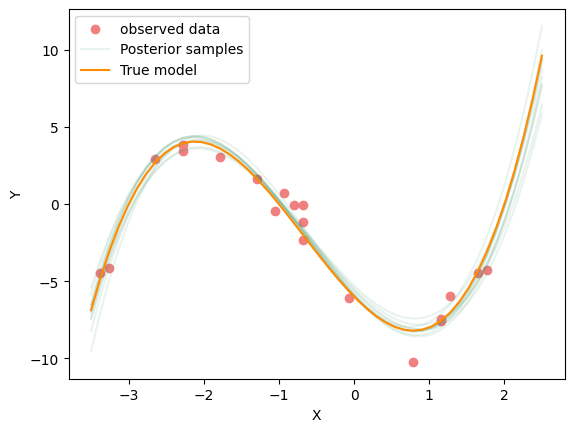

In [36]:
#@title Solution

# change number of steps
nsteps = 400              # instead of 10000

# change number of walkers
nwalkers = 30             # instead of 32
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

# let's return to the old uncertainty settings
sigma = 1.0                                 # common noise standard deviation
Cdinv = np.eye(len(data_y))/(sigma**2)      # inverse data covariance matrix

# re-defining the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probbability)

######## re-run the sampler
sampler.run_mcmc(walkers_start, nsteps, progress=True)

######## CoFI InversionResult - plot result
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=10) # get a random selection from posterior ensemble

print(f"Inference results from {nsteps} steps and {nwalkers} walkers")
plot_data()
plot_models(flat_samples[inds])
plot_model(x,true_y, "True model", color="darkorange")

In [37]:
watermark_list = ["numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

numpy 1.26.4
scipy 1.15.2
matplotlib 3.8.4
emcee 3.1.6
arviz 0.21.0
